## Imports

In [1]:
import multiprocessing as mp
from typing import Any, Literal
import numpy as np
import pandas as pd
import requests
from tqdm import tqdm
from bs4 import BeautifulSoup
import nsepython as nse
import logging
import duckdb

logging.basicConfig(
    level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s"
)


from huggingface_hub.inference_api import InferenceApi
import os

from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta

/Users/shubxam/projects/Nifty-500-Live-Sentiment-Analysis/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import concurrent.futures

## Constants and Global Variables

In [3]:
universe = "nifty_500"
news_url = "https://www.google.com/finance/quote"
header = {
    "User-Agent": "Mozilla/5.0 (Windows NT 6.1; WOW64; rv:20.0) Gecko/20100101 Firefox/20.0"
}
token = os.getenv("hf_api_key")
# sentiment_model_1 = InferenceApi("ProsusAI/finbert", token=token)
sentiment_model = InferenceApi(
    "mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis", token=token
)

/Users/shubxam/projects/Nifty-500-Live-Sentiment-Analysis/.venv/lib/python3.10/site-packages/huggingface_hub/utils/_deprecation.py:131: FutureWarning: 'InferenceApi' (from 'huggingface_hub.inference_api') is deprecated and will be removed from version '1.0'. `InferenceApi` client is deprecated in favor of the more feature-complete `InferenceClient`. Check out this guide to learn how to convert your script to use it: https://huggingface.co/docs/huggingface_hub/guides/inference#legacy-inferenceapi-client.
  warnings.warn(warning_message, FutureWarning)


## Get the list of stocks in the universe

In [4]:
def fetch_tickers() -> None:
    """
    Fetches the tickers for the specified Nifty index.

    Returns:
        pandas.DataFrame: A DataFrame containing the tickers and company names.
    """

    # check if a directory datasets exists in root folder if not then create it
    if not os.path.exists("./datasets"):
        os.makedirs("./datasets")

    # Dictionary to store the URLs for the different Nifty indices
    tickers_url_dict: dict = {
        "nifty_500": "https://archives.nseindia.com/content/indices/ind_nifty500list.csv",
        "nifty_200": "https://archives.nseindia.com/content/indices/ind_nifty200list.csv",
        "nifty_100": "https://archives.nseindia.com/content/indices/ind_nifty100list.csv",
        "nifty_50": "https://archives.nseindia.com/content/indices/ind_nifty50list.csv",
    }

    logging.info(f"Downloading Tickers List for {list(tickers_url_dict.keys())}")

    for index_name in tickers_url_dict.keys():
        try:
            ticker_list_url = tickers_url_dict[index_name]
            ticker_list_df = pd.read_csv(ticker_list_url)
            ticker_list_df.to_csv(f"./datasets/{index_name}.csv")
        except Exception as e:
            logging.warning(f"Error fetching tickers for {index_name}: {e}")

In [5]:
fetch_tickers()
tickers_df = pd.read_csv(f"./datasets/{universe}.csv")
tickers_list = list(tickers_df["Symbol"])

2024-08-30 17:26:35,788 - INFO - Downloading Tickers List for ['nifty_500', 'nifty_200', 'nifty_100', 'nifty_50']


## Fetch News Data and MetaData

In [6]:
def get_url_content(
    ticker: str,
) -> tuple[None, None, None] | tuple[str, BeautifulSoup, dict]:
    _ticker: str = ticker + ":NSE"
    url = f"{news_url}/{_ticker}"
    logging.debug(f"Fetching data for {ticker} from {url}")
    try:
        response: requests.Response = requests.get(url, headers=header)
        soup: BeautifulSoup = BeautifulSoup(response.content, "lxml")
    except Exception as e:
        logging.warning(f"Error fetching data for {ticker}: {e}")
        return None, None, None
    meta: dict = nse.nse_eq(ticker)
    return ticker, soup, meta

In [7]:
def parse_relative_date(date_string) -> None | datetime:
    now = datetime.now()
    parts = date_string.split()

    if len(parts) != 2 and len(parts) != 3:
        return None

    value = int(parts[0]) if parts[0] != "a" else 1
    unit = parts[1]

    if unit.startswith("minute"):
        return now - timedelta(minutes=value)
    elif unit.startswith("hour"):
        return now - timedelta(hours=value)
    elif unit.startswith("day"):
        return now - timedelta(days=value)
    elif unit.startswith("week"):
        return now - timedelta(weeks=value)
    elif unit.startswith("month"):
        return now - relativedelta(months=value)
    else:
        return None

In [8]:
def ticker_article_fetch(
    ticker, soup
) -> tuple[list, Literal[True]] | tuple[list, Literal[False]]:
    article_data = []
    news_articles: list = soup.select("div.z4rs2b")

    if not news_articles:
        logging.warning(f"No news found for {ticker}")
        return article_data, True

    ticker_articles_counter = 0

    for link in news_articles:
        art_title: str = link.select_one("div.Yfwt5").text.strip().replace("\n", "")
        date_posted_str: str = link.select_one("div.Adak").text
        date_posted: str = parse_relative_date(date_posted_str).strftime(
            "%Y-%m-%d %H:%M:%S"
        )
        source: str = link.select_one("div.sfyJob").text
        article_link: str = link.select_one("a").get("href")

        article_data.append([ticker, art_title, date_posted, source, article_link])
        ticker_articles_counter += 1

    logging.debug(f"No of articles: {ticker_articles_counter} for {ticker}")
    return article_data, False

In [9]:
def ticker_meta_fetch(ticker: str, meta: dict) -> list:
    try:
        sector: str = meta["industryInfo"]["macro"]
        industry: str = meta["industryInfo"]["industry"]
        mCap: float = round(
            (meta["priceInfo"]["previousClose"] * meta["securityInfo"]["issuedSize"])
            / 1e9,
            2,
        )
        companyName: str = meta["info"]["companyName"]
    except KeyError as e:
        logging.warning(f"Error fetching metadata for {ticker}: {e}")
        sector = industry = mCap = companyName = np.nan
    return [ticker, sector, industry, mCap, companyName]

In [10]:
def process_ticker(ticker: str) -> dict[str, Any]:
    try:
        ticker, soup, meta = get_url_content(ticker)
        article_data, no_news = ticker_article_fetch(ticker, soup)
        if no_news:
            logging.info(f"Skipping meta check for {ticker}")
            return {
                "ticker": ticker,
                "article_data": [],
                "ticker_meta": None,
                "unavailable": True,
            }
        ticker_meta = ticker_meta_fetch(ticker, meta)
        return {
            "ticker": ticker,
            "article_data": article_data,
            "ticker_meta": ticker_meta,
            "unavailable": False,
        }
    except Exception as e:
        logging.warning(f"Error processing {ticker}: {e}")
        return {
            "ticker": ticker,
            "article_data": [],
            "ticker_meta": None,
            "unavailable": True,
        }

In [11]:
ticker_data = []

with concurrent.futures.ThreadPoolExecutor(max_workers=mp.cpu_count()) as executor:

    futures = [executor.submit(process_ticker, ticker) for ticker in tickers_list]

    ticker_data = [future.result() for future in tqdm(futures)]

 15%|█▍        | 75/502 [00:43<03:33,  2.00it/s]

Please use nse_fno() function to reduce latency.
Please use nse_fno() function to reduce latency.


2024-08-30 17:28:11,080 - WARNING - No news found for DUMMYRAYMD
2024-08-30 17:28:11,081 - INFO - Skipping meta check for DUMMYRAYMD
2024-08-30 17:28:11,081 - INFO - Skipping meta check for DUMMYRAYMD
2024-08-30 17:28:14,983 - WARNING - No news found for DUMMYSANOF
2024-08-30 17:28:14,983 - INFO - Skipping meta check for DUMMYSANOF
2024-08-30 17:28:37,770 - WARNING - Error fetching data for BIOCON: HTTPSConnectionPool(host='www.google.com', port=443): Max retries exceeded with url: /finance/quote/BIOCON:NSE (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0x12c7702b0>, 'Connection to www.google.com timed out. (connect timeout=None)'))
2024-08-30 17:28:37,770 - WARNING - Error processing None: 'NoneType' object has no attribute 'select'
 73%|███████▎  | 364/502 [03:34<01:42,  1.34it/s]2024-08-30 17:30:19,273 - WARNING - No news found for PPLPHARMA
2024-08-30 17:30:19,274 - INFO - Skipping meta check for PPLPHARMA
 78%|███████▊  | 393/502 [03:50<01:02,  1.73it

In [12]:
article_data = []
ticker_meta = []
unavailable_tickers = []

for result in ticker_data:
    if result["unavailable"]:
        unavailable_tickers.append(result["ticker"])
    else:
        article_data.extend(result["article_data"])
        ticker_meta.append(result["ticker_meta"])

In [13]:
logging.info(f"No news data available for: {unavailable_tickers}")

2024-08-30 17:31:48,917 - INFO - No news data available for: ['ABBOTINDIA', None, 'DUMMYRAYMD', 'DUMMYSANOF', 'MARUTI', 'PPLPHARMA', 'RELIANCE']


In [14]:
article_df = pd.DataFrame(
    article_data,
    columns=["ticker", "headline", "date_posted", "source", "article_link"],
)
article_df.tail()

,ticker,headline,date_posted,source,article_link
2145,ZYDUSLIFE,"Stocks to Watch: Jio Financial Services, ICICI...",2024-08-28 17:31:40,mint,https://www.livemint.com/market/stock-market-n...
2146,ZYDUSLIFE,"Brokerage Radar: United Spirits, Zydus Life ba...",2024-08-28 17:31:40,Moneycontrol,https://www.moneycontrol.com/news/business/bro...
2147,ZYDUSLIFE,"डबल अपग्रेड हुआ ये Pharma Stock, ब्रोकरेज सुपर...",2024-08-28 17:31:40,Zee Business,https://www.zeebiz.com/hindi/stock-markets/sto...
2148,ZYDUSLIFE,"Hot stocks: Brokerage view on L&T Finance, Ind...",2024-08-28 17:31:40,The Economic Times,https://m.economictimes.com/markets/stocks/new...
2149,ECLERX,"This mid-cap IT party is getting lit; NIIT, Da...",2024-08-27 17:31:40,Moneycontrol,https://www.moneycontrol.com/news/business/mar...


In [15]:
ticker_meta_df = pd.DataFrame(
    ticker_meta,
    columns=["ticker", "sector", "industry", "marketCap", "companyName"],
)

## Sentiment Analysis

In [16]:
logging.info("Performing Sentiment Analysis")

2024-08-30 17:31:53,636 - INFO - Performing Sentiment Analysis


In [17]:
articles_list = article_df.headline.astype(str).tolist()
sentiment_scores = sentiment_model(article_df.headline.astype(str).tolist())

In [18]:
index = 103
print(f"headline: {articles_list[index]}")
print(
    f"""sentiment score: 
      {sentiment_scores[index][0]['label']}: {sentiment_scores[index][0]['score']}
      {sentiment_scores[index][1]['label']}: {sentiment_scores[index][1]['score']}
      {sentiment_scores[index][2]['label']}: {sentiment_scores[index][2]['score']}"""
)

headline: Most bonus shares — These Nifty companies have issued free stock the most times; do you own any?
sentiment score: 
      neutral: 0.9998911619186401
      negative: 6.778783426852897e-05
      positive: 4.1013929148903117e-05


In [19]:
def perform_sentiment_analysis(headline: list[str]) -> pd.DataFrame:

    results: list = sentiment_model(headline)

    # Initialize an empty list to hold the flattened data
    flattened_data: list = []

    for list_item in results:
        score_dict = dict()
        for dict_item in list_item:
            sentiment = dict_item["label"]
            sentiment_score = dict_item["score"]
            score_dict[sentiment] = sentiment_score
        flattened_data.append(score_dict)

    # Create the DataFrame
    df = pd.DataFrame(flattened_data)

    # Calculate the compound score
    df.loc[:, "compound"] = df.loc[:, "positive"] - df.loc[:, "negative"]
    return df

In [20]:
sentiment_scores_df = perform_sentiment_analysis(
    article_df.headline.astype(str).tolist()
)

In [21]:
sentiment_scores_df.head()

,positive,neutral,negative,compound
0,0.999497,0.000319,0.000184,0.999313
1,0.999225,0.000534,0.000241,0.998983
2,0.000440,0.005712,0.993847,-0.993407
3,0.999605,0.000188,0.000207,0.999398
4,0.000041,0.999891,0.000068,-0.000027


In [22]:
article_df = pd.merge(
    article_df, sentiment_scores_df, left_index=True, right_index=True
)

In [23]:
article_df.tail()

,ticker,headline,date_posted,source,article_link,positive,neutral,negative,compound
2145,ZYDUSLIFE,"Stocks to Watch: Jio Financial Services, ICICI...",2024-08-28 17:31:40,mint,https://www.livemint.com/market/stock-market-n...,0.000061,0.999851,0.000087,-0.000026
2146,ZYDUSLIFE,"Brokerage Radar: United Spirits, Zydus Life ba...",2024-08-28 17:31:40,Moneycontrol,https://www.moneycontrol.com/news/business/bro...,0.999534,0.000143,0.000323,0.999211
2147,ZYDUSLIFE,"डबल अपग्रेड हुआ ये Pharma Stock, ब्रोकरेज सुपर...",2024-08-28 17:31:40,Zee Business,https://www.zeebiz.com/hindi/stock-markets/sto...,0.000076,0.999847,0.000078,-0.000002
2148,ZYDUSLIFE,"Hot stocks: Brokerage view on L&T Finance, Ind...",2024-08-28 17:31:40,The Economic Times,https://m.economictimes.com/markets/stocks/new...,0.000059,0.999873,0.000068,-0.000010
2149,ECLERX,"This mid-cap IT party is getting lit; NIIT, Da...",2024-08-27 17:31:40,Moneycontrol,https://www.moneycontrol.com/news/business/mar...,0.999426,0.000373,0.000201,0.999225


## Adding data into DuckDB

In [24]:
conn = duckdb.connect("./datasets/ticker_data.db")

In [25]:
# create a new table for storing article data

conn.execute(
    "CREATE TABLE IF NOT EXISTS article_data (ticker TEXT, headline TEXT, date_posted TEXT, source TEXT, article_link TEXT, negative_sentiment FLOAT, positive_sentiment FLOAT, neutral_sentiment FLOAT, compound_sentiment FLOAT)"
)

# insert article data into the table
# conn.executemany("INSERT INTO article_data VALUES (?, ?, ?, ?, ?)", article_data)

In [ ]:
conn.execute("""
    INSERT INTO article_data SELECT * FROM article_df
"""
)

In [ ]:
conn.sql("SELECT * FROM article_data").fetchdf()

In [ ]:
# create a new table for storing ticker metadata

conn.execute(
    "CREATE or REPLACE TABLE ticker_meta (ticker TEXT, sector TEXT, industry TEXT, mCap REAL, companyName TEXT)"
)

# insert ticker metadata into the table, this table will be replaced on every run.
conn.executemany("INSERT into ticker_meta VALUES (?, ?, ?, ?, ?)", ticker_meta)

In [ ]:
conn.execute("SELECT * from ticker_meta limit 5").df()

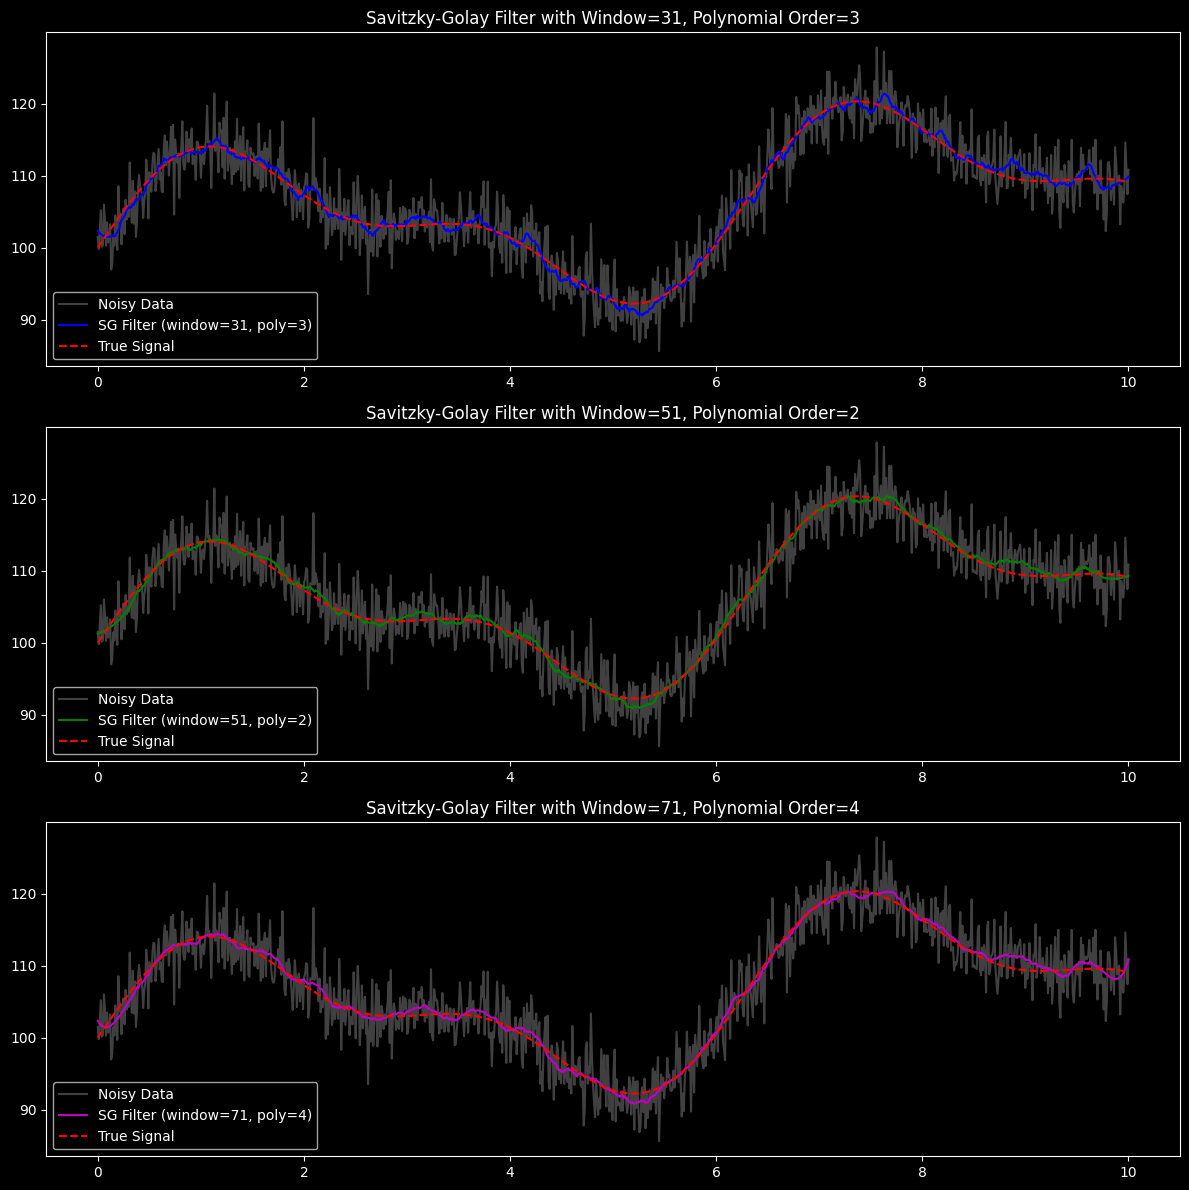

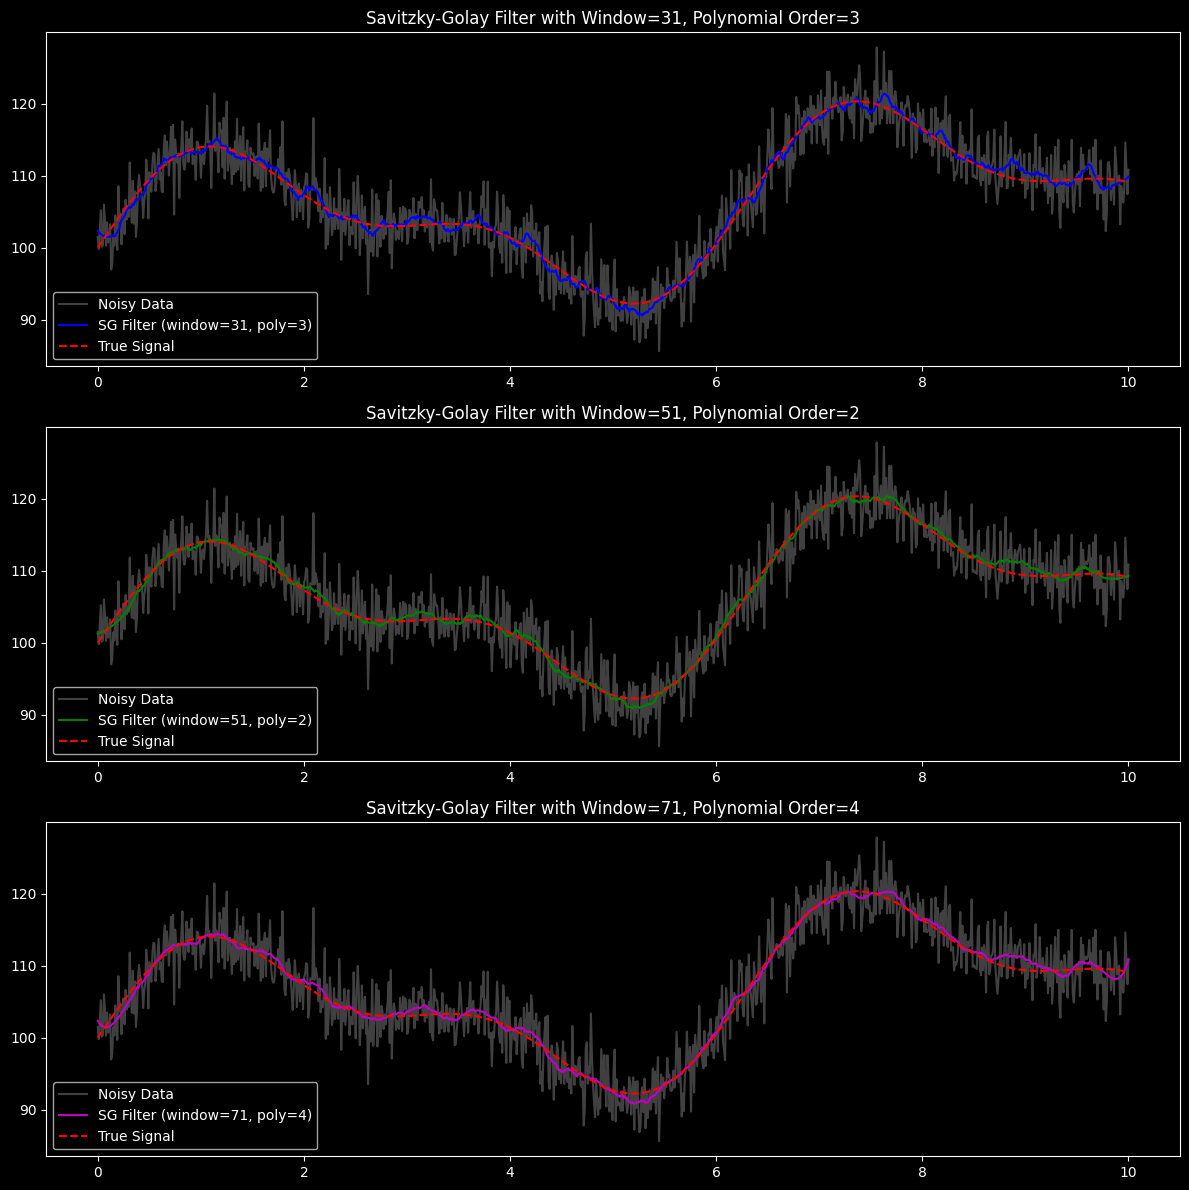

In [1]:
import numpy as np
import pandas as pd
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt

def demonstrate_savgol():
    # Generate sample price data with noise
    np.random.seed(42)
    x = np.linspace(0, 10, 1000)
    # Create a synthetic price movement with multiple features
    true_signal = 100 + 10 * np.sin(x) + 5 * np.sin(2*x) + x
    # Add random noise
    noisy_data = true_signal + np.random.normal(0, 3, true_signal.shape)
    
    # Apply Savitzky-Golay filter with different parameters
    # Window length must be odd and greater than polyorder
    smoothed_5_3 = savgol_filter(noisy_data, window_length=31, polyorder=3)
    smoothed_5_2 = savgol_filter(noisy_data, window_length=51, polyorder=2)
    smoothed_5_4 = savgol_filter(noisy_data, window_length=71, polyorder=4)
    
    # Create subplots
    fig, axes = plt.subplots(3, 1, figsize=(12, 12))
    
    # Original vs Smoothed (window=31, polyorder=3)
    axes[0].plot(x, noisy_data, 'gray', alpha=0.5, label='Noisy Data')
    axes[0].plot(x, smoothed_5_3, 'b', label='SG Filter (window=31, poly=3)')
    axes[0].plot(x, true_signal, 'r--', label='True Signal')
    axes[0].set_title('Savitzky-Golay Filter with Window=31, Polynomial Order=3')
    axes[0].legend()
    
    # Different window sizes
    axes[1].plot(x, noisy_data, 'gray', alpha=0.5, label='Noisy Data')
    axes[1].plot(x, smoothed_5_2, 'g', label='SG Filter (window=51, poly=2)')
    axes[1].plot(x, true_signal, 'r--', label='True Signal')
    axes[1].set_title('Savitzky-Golay Filter with Window=51, Polynomial Order=2')
    axes[1].legend()
    
    # Different polynomial orders
    axes[2].plot(x, noisy_data, 'gray', alpha=0.5, label='Noisy Data')
    axes[2].plot(x, smoothed_5_4, 'm', label='SG Filter (window=71, poly=4)')
    axes[2].plot(x, true_signal, 'r--', label='True Signal')
    axes[2].set_title('Savitzky-Golay Filter with Window=71, Polynomial Order=4')
    axes[2].legend()
    
    plt.tight_layout()
    return fig

# Generate demonstration plot
demonstrate_savgol()

# article extraction from finology ticker

In [1]:
import os
import sys

sys.path.append(os.path.join(os.path.abspath(os.path.pardir), "src"))

In [2]:
from utils import get_webpage_content, parse_date
from bs4 import BeautifulSoup

In [3]:
base_url = "https://ticker.finology.in/company"
ticker = "ADANIENT"
url = f"{base_url}/{ticker}"

In [4]:
response = get_webpage_content(url, custom_header=False)